# Interpretable Object Detection

## Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import brambox as bb
import lightnet as ln
import interpretability as ip

## Settings and paths

In [6]:
# Settings
bb.logger.setConsoleLevel('ERROR')             # Only show error log messages

# Setting device
device = torch.device('cpu')
if torch.cuda.is_available():
    print('CUDA enabled')
    device = torch.device('cuda')
else:
    print('CUDA not available')
    
# Variables
detection_threshold = 0.5
    
# Path variables
network_path = 'cfg/yolo.py'
annos_path = 'data/VOCdevkit/VOC2007/Annotations/'
weights_path = 'weights/yolov2-voc.pt'

# Load annotations
anno = bb.io.load('pandas', 'data/annotations.pkl')
det = bb.io.load('pandas', 'data/detections.pkl')

CUDA enabled


## Picking interesting images

In [11]:
my_class = 'horse' # Which class to look at
# aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike, person, pottedplant, sheep, sofa, train, tvmonitor

anno = anno[anno['class_label'] == my_class]
det = det[det['class_label'] == my_class]

filtered_det = det

"""pr = bb.stat.pr(det, anno, 0.5)  # IoU threshold of 0.5
ap = bb.stat.ap(pr)

# Find detection threshold with maximal F1
f1 = bb.stat.fscore(pr)
threshold = bb.stat.peak(f1)

# Filter detections based on threshold (computed in previous step from F1-curve)
filtered_det = det[det.confidence >= threshold.confidence].copy()"""

# Compute TP,FP
tpfp_det = bb.stat.match_det(filtered_det, anno, 0.0)
# match_det() returns detections with a 'tp' and 'fp' column.
print('TP FP:')
tpfp_det = tpfp_det[tpfp_det['fp']]
tpfp_det = tpfp_det[tpfp_det['confidence'] > 0.7]
tpfp_det = tpfp_det.drop_duplicates(['image'])
display(tpfp_det.sort_values(['confidence'], ascending=False))
chosen_images = tpfp_det.image

# Compute FN
fn_anno = bb.stat.match_anno(filtered_det, anno, 0.0, bb.stat.IgnoreMethod=0)
# match_anno() returns annotations with a 'detection' column that has the index of the matched detection
# We use this to filter unmatched annotations (NaN as index)
fn_anno = fn_anno[fn_anno.detection.isnull()]
fn_anno = fn_anno.drop_duplicates(['image'])
print('FN:')
display(fn_anno)
chosen_images = chosen_images.append(fn_anno.image)

SyntaxError: keyword can't be an expression (<ipython-input-11-f8830405b277>, line 30)

## Run Backprogation

INFO       Loading weights from file [weights/yolov2-voc.pt]


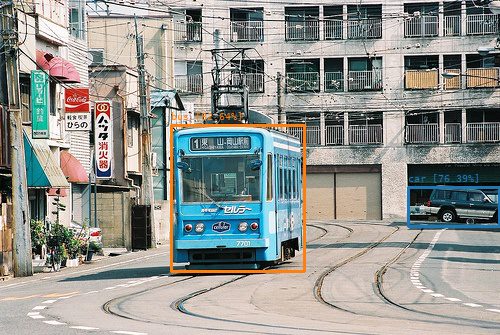

Detections:


,image,class_label,x_top_left,y_top_left,width,height,confidence,anchor_box,status
0,VOC2007/JPEGImages/004578,bus,142.74501,172.554138,110.753868,120.989853,0.826434,1.0,FP


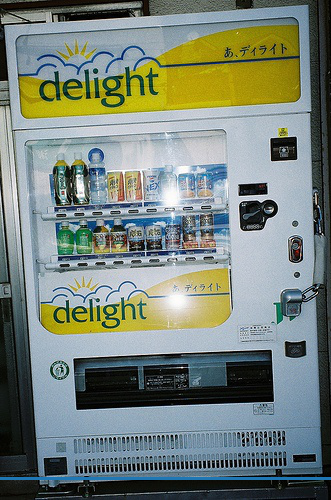

Detections:


,image,class_label,x_top_left,y_top_left,width,height,confidence,anchor_box,status
0,VOC2007/JPEGImages/000893,bus,57.894012,-28.031326,293.754059,426.19812,0.603119,4.0,FP


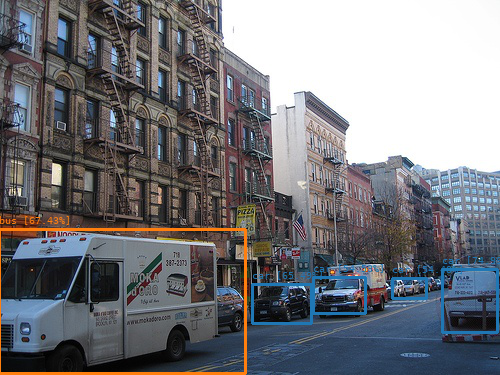

Detections:


,image,class_label,x_top_left,y_top_left,width,height,confidence,anchor_box,status
0,VOC2007/JPEGImages/009829,bus,-1.522232,243.1259,205.641998,119.560768,0.674291,3.0,FP


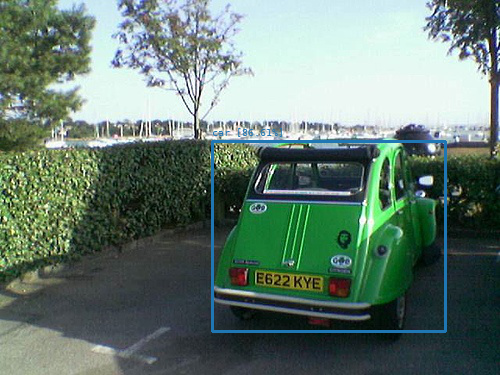

ValueError: zero-size array to reduction operation maximum which has no identity

In [4]:
# Initialize network and load weights
params = ln.engine.HyperParameters.from_file(network_path)
params.network.load(weights_path)
params.post[0].conf_thresh = detection_threshold   # Overwrite threshold

gradients_as_arr_list = []
count_list = []
img_tf_list = []
#chosen_images = ['VOC2007/JPEGImages/001307', 'VOC2007/JPEGImages/001307']

for image in chosen_images:
    # New path
    new_path = annos_path + image.split('/')[-1] + '.xml'
    
    # Load annos
    annos = bb.io.load('anno_pascalvoc', new_path, ip.identify)
    annos = annos[annos['class_label'] == my_class]
    
    # Get detections
    det_img, detections = ip.run_detect(params, new_path, device, detection_threshold)
    display(ip.utils.show_image(det_img))
    detections.image = image
    detections.image = detections.image.astype('category')
    detections = detections[detections['class_label'] == my_class]
    
    # Run model
    img_tf, annos = ip.transform(params, annos, new_path)

    # Compute TP,FP
    tpfp_det = bb.stat.match_det(detections, annos, detection_threshold)
    # match_det() returns detections with a 'tp' and 'fp' column.

    # Compute FN
    fn_anno = bb.stat.match_anno(detections, annos, 0.5)
    # match_anno() returns annotations with a 'detection' column that has the index of the matched detection
    # We use this to filter unmatched annotations (NaN as index)
    fn_anno = fn_anno[fn_anno.detection.isnull()]
    
    # Add status column
    tpfp_det['status'] = 'FP'                     # Make all boxes FP
    tpfp_det.loc[tpfp_det.tp, 'status'] = 'TP'  # Make TP boxes TP
    fn_anno['status'] = 'FN'                     # Make FN boxes FN
    
    # Add extra columns to fn_anno to be able to combine dataframes
    fn_anno['anchor_box'] = ''
    fn_anno['confidence'] = ''

    # Only keep necessary columns (to be able to combine dataframes)
    boxes1 = tpfp_det[['image', 'class_label', 'x_top_left', 'y_top_left', 'width', 'height', 'confidence', 'anchor_box', 'status']]
    boxes2 = fn_anno[['image', 'class_label', 'x_top_left', 'y_top_left', 'width', 'height', 'confidence', 'anchor_box', 'status']]

    # Concatenate dataframes
    boxes = bb.util.concat([boxes1, boxes2], sort=False, ignore_index=True)
    
    print('Detections:')
    display(boxes)
    
    # Vanilla backprop
    VBP = ip.backprop.VanillaBackprop(params, device)

    # Generate gradients
    gradients_as_arr = VBP.generate_gradients(params, img_tf, device, boxes, True, True)
    img_tf_list.append(img_tf.data.cpu().numpy()[0])
    count_list.append(len(gradients_as_arr))
    for gradient in gradients_as_arr:
        gradients_as_arr_list.append(gradient)

## Show images on screen

In [ ]:
# Normalize to grayscale and show images
gradients_list = ip.utils.normalize(gradients_as_arr_list, True)
count1 = 0
count2 = 0

for gradient in gradients_list:
    if count1 == count_list[count2]:
        count2 += 1
        count1 = 0
    img = ip.utils.show_image(gradient).convert("L")
    display(img)
    img_tf_show = ip.utils.show_image(img_tf_list[count2])
    img_tf_show.paste(img, (0, 0), img)
    display(img_tf_show)
    count1 += 1

# End